# Importing libraries to first do some explore on dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
df=pd.read_excel("Life Expectancy at Birth.xlsx")

In [4]:
df.head()

,Country,Country Code,Region,Income Group,Year,Life Expectancy
0,Aruba,ABW,Latin America & Caribbean,High income,1960,65.569366
1,Afghanistan,AFG,South Asia,Low income,1960,32.328512
2,Angola,AGO,Sub-Saharan Africa,Lower middle income,1960,32.984829
3,Albania,ALB,Europe & Central Asia,Upper middle income,1960,62.254366
4,Andorra,AND,Europe & Central Asia,High income,1960,NaN


We will not need it, it's the same as the country

In [168]:
df=df.drop("Country Code",axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14728 entries, 0 to 14727
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Country          14728 non-null  object 
 1   Region           12152 non-null  object 
 2   Income Group     12152 non-null  object 
 3   Year             14728 non-null  int64  
 4   Life Expectancy  13498 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 402.8+ KB


In [9]:
df.describe()

,Year,Life Expectancy
count,14728.000000,13498.000000
mean,1987.500000,63.303497
std,16.163779,11.231589
min,1960.000000,19.265512
25%,1973.750000,55.095858
50%,1987.500000,66.081646
75%,2001.250000,71.836439
max,2015.000000,84.278049


We have lots of missing values

In [7]:
df.isnull().sum()

Country               0
Region             2576
Income Group       2576
Year                  0
Life Expectancy    1230
dtype: int64

<AxesSubplot:>

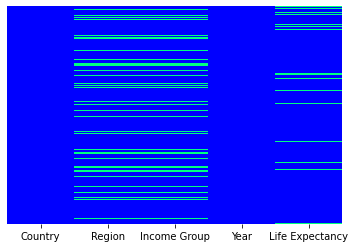

In [10]:
sns.heatmap(df.isnull(),cmap="winter",yticklabels=False,cbar=False)

In [14]:
df["Country"].value_counts()

Aruba                                     56
Malawi                                    56
North America                             56
Namibia                                   56
New Caledonia                             56
                                          ..
High income                               56
Hong Kong SAR, China                      56
Honduras                                  56
Heavily indebted poor countries (HIPC)    56
Zimbabwe                                  56
Name: Country, Length: 263, dtype: int64

In [215]:
df["Year"].unique

<bound method Series.unique of 0        1960
1        1960
2        1960
3        1960
4        1960
         ... 
13493    2015
13494    2015
13495    2015
13496    2015
13497    2015
Name: Year, Length: 13498, dtype: int64>

In [15]:
df["Region"].value_counts()

Europe & Central Asia         3248
Sub-Saharan Africa            2688
Latin America & Caribbean     2352
East Asia & Pacific           2072
Middle East & North Africa    1176
South Asia                     448
North America                  168
Name: Region, dtype: int64

We do not need region because we have country which is smaller scale and it can provide more info revealing region(*for example two countries may be beside eachother but their life expectacies may be differant that's why I am dropping the region*)

In [169]:
df=df.drop("Region",axis=1)

Life expectancy is our y axis so we can not modify it so we have to just remove it (*we can traing our model and if we get a good reslut we can use it to predict the missing values but now we do not really need that*)

In [170]:
df=df[df['Life Expectancy'].notna()]

In the upper box I took every information except nans

<AxesSubplot:>

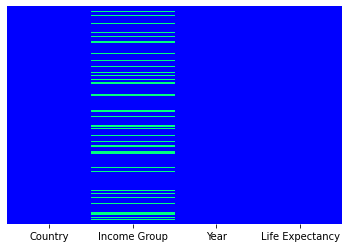

In [19]:
sns.heatmap(df.isnull(),cmap="winter",yticklabels=False,cbar=False)

In [20]:
df["Income Group"].value_counts()

High income            3443
Lower middle income    2917
Upper middle income    2826
Low income             1736
Name: Income Group, dtype: int64

We can replace income group only based on life expectancy it has two reasons:

**1. survay is done based on individuals** 

This means all of the income groups from one country are included so we can not predict them using country.

**2. There is actully a relation between income and life expectancy as shown below**

(array([0, 1, 2, 3]),
 [Text(0, 0, 'High income'),
  Text(1, 0, 'Low income'),
  Text(2, 0, 'Lower middle income'),
  Text(3, 0, 'Upper middle income')])

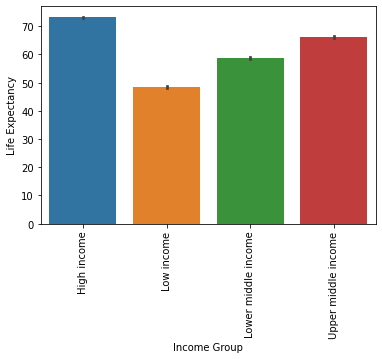

In [22]:
sns.barplot(data=df,x="Income Group",y="Life Expectancy")
plt.xticks(rotation=90)

So lets find exact numbers then define a range for each group and replace them (but since we have a large data I will just pass them)

In [64]:
maximum=pd.pivot_table(data=df,index=["Income Group"],aggfunc={"Life Expectancy":max})
maximum=maximum.rename(columns={"Life Expectancy":"High margin"})

,High margin
Income Group,
High income,84.278049
Low income,70.337927
Lower middle income,75.777732
Upper middle income,79.628610


In [60]:
le=le.sort_values(by="High margin")

In [65]:
maximum=maximum.sort_values(by="High margin")
maximum

,High margin
Income Group,
Low income,70.337927
Lower middle income,75.777732
Upper middle income,79.628610
High income,84.278049


The gap between two indexes is the amout of absolut{lower index}

for example any life expectancy between 80 and 84 is absolute High income

In [68]:
maximum["Low margin"]=[0,70.3,75.7,79.6]
maximum=maximum.drop("Low income",axis=0)

In [73]:
maximum

,High margin,Low margin
Income Group,,
Lower middle income,75.777732,70.3
Upper middle income,79.600000,75.7
High income,84.278049,79.6


In [171]:
df=df.reset_index()

In [172]:
df=df.drop("index",axis=1)

In [144]:
import numpy as np

In [200]:
frame=[]
for x in range(len(df["Life Expectancy"])):
    if pd.isnull(df["Income Group"][x]):
        if x<le["High margin"][2] and x>le["Low margin"][2]:
            frame.append("High income")
        elif x<le["High margin"][1] and x>le["Low margin"][1]:
            frame.append("Upper middle income")
        elif x<le["High margin"][0] and x>le["Low margin"][0]:
            frame.append("Lower middle income")
        else:
            frame.append("Low income")
    else:
        frame.append(df["Income Group"][x])

In [202]:
df["Income Group"]=frame

In [204]:
df.isnull().sum()

Country            0
Income Group       0
Year               0
Life Expectancy    0
dtype: int64

Now lets replace non numeric with numeric ones 

In [207]:
frame=[]
for x in range(len(df["Income Group"])):
    if(df["Income Group"][x]=="High income"):
        frame.append(0)
    elif(df["Income Group"][x]=="Upper middle income"):
        frame.append(1)
    elif(df["Income Group"][x]=="Lower middle income"):
        frame.append(2)
    else:
        frame.append(3)

In [209]:
df["Income Group"]=frame

In [210]:
df.head()

,Country,Income Group,Year,Life Expectancy
0,Aruba,0,1960,65.569366
1,Afghanistan,3,1960,32.328512
2,Angola,2,1960,32.984829
3,Albania,1,1960,62.254366
4,Arab World,3,1960,46.852780


# Now that our dataframe is acceptable let's get some general information of it

<AxesSubplot:xlabel='Life Expectancy', ylabel='Count'>

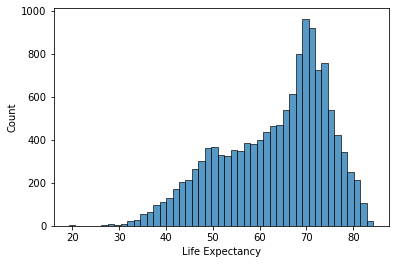

In [256]:
sns.histplot(df["Life Expectancy"])

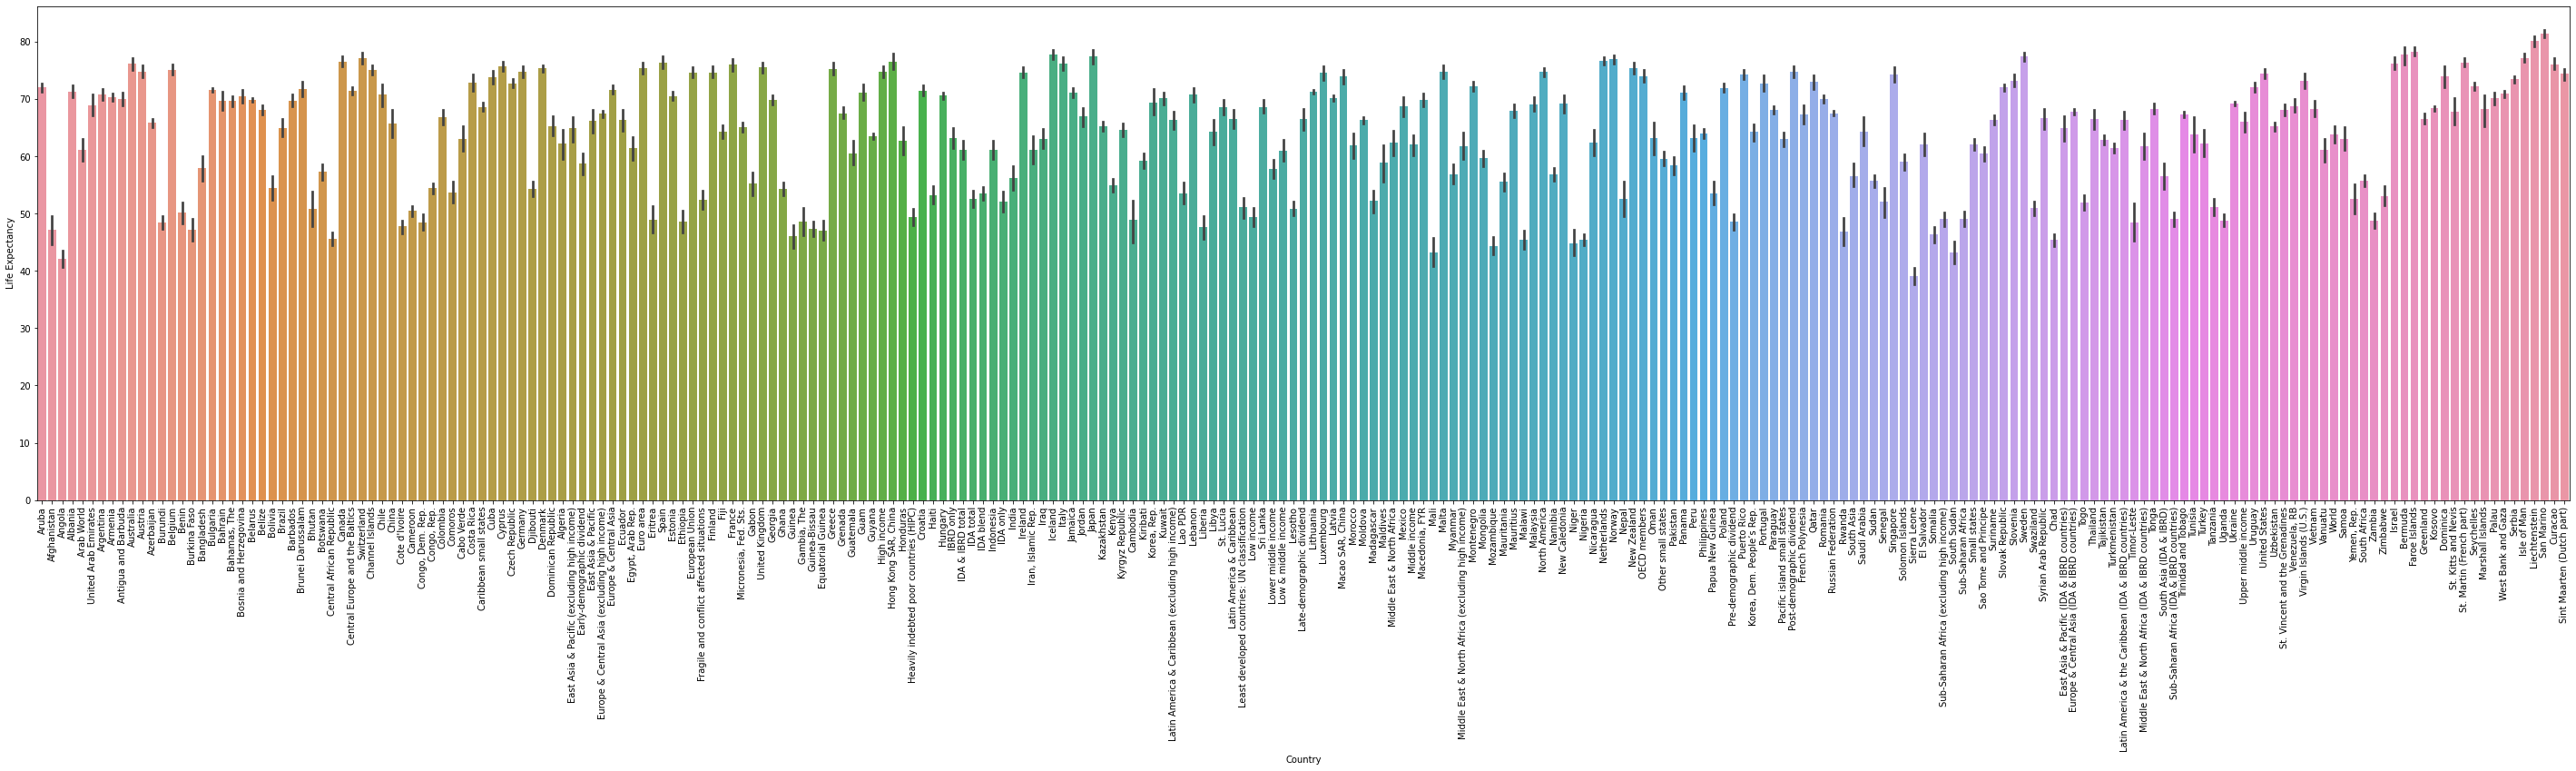

In [216]:
plt.figure(figsize=(50,10))
sns.barplot(data=df,x="Country",y="Life Expectancy")
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Life Expectancy'>

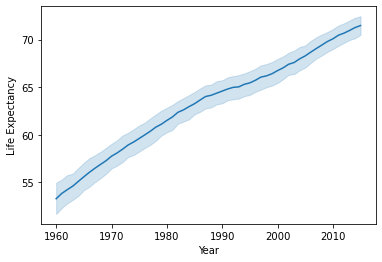

In [217]:
sns.lineplot(data=df,x="Year",y="Life Expectancy")

In order to replace countries with numbers I have to use get dummies which I do not like becaude it makes dataset look messed up but due to the number of countries I have to use it

In [218]:
frame=[]
frame=pd.get_dummies(df["Country"],drop_first=True)

In [220]:
df=df.drop("Country",axis=1)

In [221]:
df=pd.concat([frame,df],axis=1)

In [222]:
df.head()

,Albania,Algeria,Angola,Antigua and Barbuda,Arab World,Argentina,Armenia,Aruba,Australia,Austria,...,Vietnam,Virgin Islands (U.S.),West Bank and Gaza,World,"Yemen, Rep.",Zambia,Zimbabwe,Income Group,Year,Life Expectancy
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1960,65.569366
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1960,32.328512
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,1960,32.984829
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1960,62.254366
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1960,46.852780


In [224]:
df.shape

(13498, 255)

In [225]:
x=df.drop("Life Expectancy",axis=1)
y=df["Life Expectancy"]

In [226]:
from sklearn.model_selection import train_test_split

In [227]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y)

# Linear Regression

In [228]:
from sklearn.linear_model import LinearRegression

In [229]:
lr=LinearRegression()

In [230]:
prediction=lr.fit(xtrain,ytrain).predict(xtest)

In [231]:
from sklearn import metrics

In [232]:
metrics.mean_squared_error(prediction,ytest)

9.593425375399743

In [235]:
df["Life Expectancy"].describe()

count    13498.000000
mean        63.303497
std         11.231589
min         19.265512
25%         55.095858
50%         66.081646
75%         71.836439
max         84.278049
Name: Life Expectancy, dtype: float64

so as in general we have a 9.6/63 percent of error(15 %)

# KNN

In [236]:
from sklearn.neighbors import KNeighborsRegressor

In [237]:
knn=KNeighborsRegressor()

In [238]:
predicion2=knn.fit(xtrain,ytrain).predict(xtest)

In [241]:
metrics.mean_squared_error(predicion2,ytest)

40.41956961615843

It did not act well lets tune it

In [242]:
knn=KNeighborsRegressor(weights="distance")

In [243]:
temp={"n_neighbors":[5,10,15,20,25,30,35,40,45,50,55,60,65,70]}

In [244]:
from sklearn.model_selection import GridSearchCV

In [245]:
gds=GridSearchCV(knn,temp)

In [246]:
tuned_knn_predicion=gds.fit(xtrain,ytrain).predict(xtest)

In [248]:
gds.best_params_

{'n_neighbors': 5}

In [249]:
gds.best_score_

0.703823471660473

In [250]:
temp={"n_neighbors":[1,2,3,4,5,6,7,8,9]}

In [251]:
gds=GridSearchCV(knn,temp)

In [252]:
tuned_knn_predicion=gds.fit(xtrain,ytrain).predict(xtest)

In [253]:
metrics.mean_squared_error(tuned_knn_predicion,ytest)

20.863322416884827

In [254]:
gds.best_params_

{'n_neighbors': 2}

In [255]:
gds.best_score_

0.7836844583132916

We could not get more than 78 percent lets remove noises and check the results

As a concludion we could get 85 precent with linear regression and 78 with knn the result is that, there is a powerful relation between parameters year and 